In [1]:
import numpy as np
import pandas as pd

In [5]:
import torch
import torch_geometric.data

/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
from torch_geometric.utils import convert

In [24]:
from torch_geometric.data import InMemoryDataset

In [56]:
from torch_geometric.data import Data, DataLoader

In [185]:
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer

In [186]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

#### Import the ordered data

In [2]:
five_gram_data = np.load("./5_gram_processed_mats.npz",allow_pickle=True)

In [3]:
# ordered_nodes: user names
# ordered_adj_mat: adjacency matrix
# ordered_node_labels: user labels
# ordered_node_features: user 5-gram featues
ordered_nodes = five_gram_data['arr_0']
ordered_adj_mat= five_gram_data['arr_1']
ordered_node_labels= five_gram_data['arr_2']
ordered_node_features= five_gram_data['arr_3']

#### Further cleaning

In [20]:
ordered_adj_mat = ordered_adj_mat.item()

In [49]:
ordered_edge_index, ordered_edge_weight = convert.from_scipy_sparse_matrix(ordered_adj_mat)

In [53]:
# convert labels to 0s and 1s
label_mapper = {'anti':0,'pro':1}
ordered_node_labels_number  = np.array([label_mapper[label] for label in ordered_node_labels ])

#### Define the dataset class as input to GNN

In [172]:
class gram5_Dataset(InMemoryDataset):
    def __init__(self,root, transform=None, pre_transform=None):
        super(gram5_Dataset, self).__init__(root,transform, pre_transform)
        
        self.data, self.slices = torch.load(self.processed_paths[0])
        

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['processed.data']

    def download(self):
        pass
    
    def process(self):
        
        print(self.processed_paths[0])
        
        data_list = []
        
        
        edge_index = ordered_edge_index
        y = torch.IntTensor(ordered_node_labels_number)
        
        data = Data(x=torch.FloatTensor(ordered_node_features), edge_index=edge_index, y=y)
        data_list.append(data)
        
        new_data, slices = self.collate(data_list)
        torch.save((new_data,slices), self.processed_paths[0])


In [126]:
ordered_node_features.shape

(239, 2500)

In [173]:
# get the graph object
gram5_graph =  gram5_Dataset(root="./generated_data/")

In [174]:
data = gram5_graph[0]

In [175]:
dataset = gram5_graph

In [176]:
data

Data(edge_index=[2, 485], x=[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], y=[239])

In [177]:
data['x'] = torch.FloatTensor(data['x'])

In [178]:
data

Data(edge_index=[2, 485], x=[239, 2500], y=[239])

#### Split the data into 80% training and 20% test

In [179]:
shuffle_idx = np.array(range(data['x'].shape[0]))
np.random.shuffle(shuffle_idx)

In [180]:
train_bool = np.array([False]*len(shuffle_idx))
test_bool = np.array([False]*len(shuffle_idx))

In [181]:
train_bool[shuffle_idx[:int(len(shuffle_idx)*0.8)]] = True
test_bool[shuffle_idx[int(len(shuffle_idx)*0.8):]] = True

In [182]:
# split train/test 8:2
data.train_mask = torch.tensor(train_bool,dtype=torch.bool)
data.test_mask = torch.tensor(test_bool,dtype=torch.bool)

In [183]:
print(data.train_mask.sum().item())
print(data.test_mask.sum().item())

191
48


#### Define a two-layer Graph Neural Network

In [184]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # dataset.num_features is 2500
        self.conv1 = GCNConv(2500, 16)
        # dataset.num_classes is 2
        self.conv2 = GCNConv(16, 2)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

#### Train the GNN

In [187]:
# Some set-ups
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

In [195]:
data.y = data.y.long()

In [196]:
# train 200 epochs
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

#### Test the GNN

In [224]:
model.eval()
_, pred = model(x, edge_index).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.9792


#### Run GNNexplainer on some interesting nodes


Explain node 10: 100%|██████████| 2000/2000 [00:04<00:00, 404.42it/s]


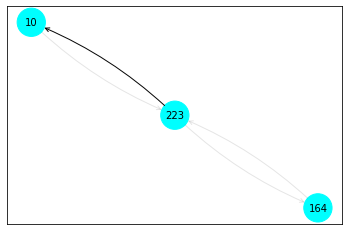

In [305]:
explainer = GNNExplainer(model, epochs=2000, lr=0.001,return_type='log_prob')
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.savefig("./node10_explain2.png")

Explain node 19: 100%|██████████| 200/200 [00:00<00:00, 377.76it/s]


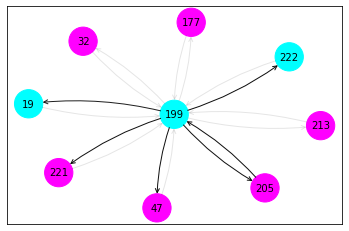

In [285]:
node_idx = 19
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.savefig("./node19_explain.png")

#### check the tweets from these users in the original datasets

In [217]:
ordered_nodes[10]

'NaomiCu82684889'

In [218]:
ordered_nodes[223]

'NLeespeaking'

In [231]:
ordered_nodes[164]

'Valkyrie20201'

In [247]:
ordered_adj_mat_np = ordered_adj_mat.toarray()

In [248]:
ordered_adj_mat_np

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [242]:
ordered_nodes[19]

'shimmerwood1'

In [287]:
ordered_nodes[205]

'NatashaForder'

In [286]:
ordered_nodes[47]

'misterstubbs'

In [243]:
ordered_nodes[199]

'JohnMappin'

In [244]:
ordered_nodes[177]

'TheFreds'

In [265]:
ordered_nodes[221]

'rainbowz08'

In [266]:
ordered_nodes[213]

'CHRISTI11638367'

In [279]:
ordered_nodes[222]

'lizzymasonart'